### **0. Libraries, Functions**

In [1]:
# Libraries
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from os import path
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.gridspec as gridspec
from sklearn.ensemble import GradientBoostingClassifier
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import os

In [2]:
def evaluate(model):
    # Assuming df, mapping_df, rfs.feature_importances_, and X.columns are defined
    y_train_pred = model.predict(X_train)

    print(f'Train accuracy: {accuracy_score(y_train, y_train_pred)}\n')

    y_test_pred = model.predict(X_test)

    print(f'Test accuracy: {accuracy_score(y_test, y_test_pred)}\n')

    print(f'{classification_report(y_test, y_test_pred)}\n')

    # Color codes for each attribute type
    color_codes = {
            'intrinsic' : '#fc7d0b',

    'extrinsic' : '#1170aa',

    'personal' : '#a3acb9'
    }

    # Creating a mapping of dummy feature names to attribute types
    attribute_type_mapping = dict(zip(mapping_df['dummy'], mapping_df['attribute_type']))

    # Creating a Series for feature importances
    feature_importance = pd.Series(
        data=model.feature_importances_,
        index=X.columns
    ).sort_values(ascending=False)

    # Set up the figure and GridSpec layout
    fig = plt.figure(figsize=(15, 10), dpi=300, constrained_layout=True)
    gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[2, 1],hspace=0.1)

    # Main plot (top)
    top_30_features = feature_importance.nlargest(30)
    sorted_indices = np.argsort(top_30_features)
    sorted_features = top_30_features.index[sorted_indices]
    sorted_importances = top_30_features.values[sorted_indices]
    main_feature_colors = [color_codes.get(attribute_type_mapping.get(feature, 'personal'), '#7f7f7f') for feature in sorted_features]

    ax0 = fig.add_subplot(gs[0, :])
    ax0.barh(sorted_features, sorted_importances, color=main_feature_colors)
    ax0.set_title('Top 30 Feature Importances', pad=15, fontsize=13)
    ax0.grid(False)
    ax0.margins(y=0, x=0)  # Adjusting Y-axis margins to fully utilize space
    sns.despine()

    # Subplots function for attribute types
    def create_subplot(attribute_type, subplot_position):
        filtered_importances = feature_importance[feature_importance.index.map(attribute_type_mapping) == attribute_type]
        top_filtered_features = filtered_importances.nlargest(10)
        sorted_indices = np.argsort(top_filtered_features)
        sorted_features = top_filtered_features.index[sorted_indices]
        sorted_importances = top_filtered_features.values[sorted_indices]

        ax = fig.add_subplot(gs[1, subplot_position])
        ax.barh(sorted_features, sorted_importances, color=color_codes[attribute_type])
        ax.set_title(f'Top 10 {attribute_type.capitalize()} Feature Importances',pad=15)
        ax.grid(False)
        ax.margins(y=0)
        sns.despine()

    # Creating subplots for each attribute type
    create_subplot('intrinsic', 0)
    create_subplot('extrinsic', 1)
    create_subplot('personal', 2)

    # Add legend to the figure
    legend_patches = [mpatches.Patch(color=color, label=atype) for atype, color in color_codes.items()]
    fig.legend(handles=legend_patches, title="Attribute Types", loc='upper right', fontsize=10, bbox_to_anchor=(1, 0.55))


    # Show the combined plot
    plt.show()

### **1. Data import & pre-processing**

In [3]:
# access to google drive
drive.mount('/content/drive')

# define the path to the CSV file in your Google Drive
file_path = '/content/drive/My Drive/wine_df_topic.csv'

# data impor
wine_df = pd.read_csv(path.join(file_path))

Mounted at /content/drive


In [4]:
wine_df.head()

,wine,winery,region,wine_style,wine_style_description,ratings_average,ratings_number,all_vintage_ratings_average,all_vintage_ratings_count,price,...,user_follower,user_following,user_total_given_ratings,user_total_sum_ratings,user_total_given_reviews,user_purchase_made,rating_label,date_review,time_review,assigned_topic
0,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,3.49,...,5.0,5.0,53.0,198.4,53.0,0.0,3.5,2022-10-01,20:16:20,affordable
1,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,3.49,...,0.0,0.0,155.0,554.1,129.0,0.0,3.5,2023-01-03,12:56:12,robust
2,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,3.49,...,66.0,148.0,628.0,2280.0,500.0,0.0,4.0,2020-04-02,12:18:29,affordable
3,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,3.49,...,102.0,132.0,472.0,1515.7,414.0,0.0,3.0,2015-06-12,14:04:45,vintage
4,Adega Cooperativa de Borba Alentejano Galitos ...,Adega Cooperativa de Borba,Alentejano,Southern Portugal White,Southern Portugal is far better known for its ...,3.4,102,3.3,8988,3.49,...,0.0,0.0,317.0,1229.3,289.0,2.0,4.0,2020-10-30,21:03:41,affordable


In [5]:
# check for cero
wine_df.isnull().sum().sum()

0

In [6]:
# check for duplicates
wine_df.duplicated().any()

False

In [7]:
# drop non meaningful
wine_df.drop(columns=['wine', 'winery',  'review','date_review', 'time_review','review_id',  'user_id'], axis=1, inplace=True)

In [8]:
wine_df.shape

(80021, 70)

### **2. Helpfunction**

In [9]:
# categorical
categorical = [var for var in wine_df.columns if wine_df[var].dtype=='O']

# numerical
numerical = [var for var in wine_df.columns if wine_df[var].dtype != 'O']

In [10]:
help_cat = wine_df[categorical]

dummies = pd.get_dummies(help_cat, columns=categorical)

original_features = ['_'.join(feature.split('_')[:-1]) for feature in list(dummies.columns)]

In [11]:
# define the path to the CSV file in your Google Drive
file_path = '/content/drive/My Drive/attribute_df.csv'

attribute_df = pd.read_csv(path.join(file_path))

In [12]:
dummy_df = pd.DataFrame({
    'original': original_features,
    'dummy': list(dummies.columns),
})

In [13]:
attribute_df_updated = attribute_df.copy()
dummy_df_updated = dummy_df.copy()

dummy_df_updated['attribute_type'] = None
dummy_df_updated['color'] = None

for i, row in dummy_df_updated.iterrows():
    original_feature = row['original']
    # Check if there's a matching feature in attribute_df_updated
    if original_feature in attribute_df_updated['feature'].values:
        # Find the corresponding attribute type and color
        attribute_type = attribute_df_updated[attribute_df_updated['feature'] == original_feature]['attribute_type'].values[0]
        color = attribute_df_updated[attribute_df_updated['feature'] == original_feature]['color'].values[0]
        dummy_df_updated.at[i, 'attribute_type'] = attribute_type
        dummy_df_updated.at[i, 'color'] = color
    else:
        # Keep the original feature if no match is found
        dummy_df_updated.at[i, 'attribute_type'] = 'original'
        dummy_df_updated.at[i, 'color'] = 'original'

In [14]:
# Deleting rows from the DataFrame where column values are in items_to_delete
df_filtered = attribute_df[~attribute_df['feature'].isin(categorical)]

df_filtered['original'] = df_filtered['feature']

df_filtered.rename({'feature': 'dummy'}, axis=1, inplace=True)

df_filtered = df_filtered[['original', 'dummy', 'attribute_type', 'color']]

<ipython-input-14-ce0ba0dadb5e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['original'] = df_filtered['feature']
<ipython-input-14-ce0ba0dadb5e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.rename({'feature': 'dummy'}, axis=1, inplace=True)


In [15]:
mapping_df = pd.concat([df_filtered, dummy_df_updated], axis=0).reset_index(drop=True)

In [16]:
mapping_df[['attribute_type','color']].value_counts()

attribute_type  color   
extrinsic       #1170aa     133
intrinsic       #fc7d0b      82
personal        #a3acb9      43
original        original      5
dtype: int64

In [17]:
mapping_df[mapping_df['attribute_type'] == 'original']

,original,dummy,attribute_type,color
258,assigned_topic,assigned_topic_affordable,original,original
259,assigned_topic,assigned_topic_analytical,original,original
260,assigned_topic,assigned_topic_robust,original,original
261,assigned_topic,assigned_topic_sweet,original,original
262,assigned_topic,assigned_topic_vintage,original,original


In [18]:
mapping_df.loc[mapping_df['attribute_type'] == 'original', 'attribute_type'] = 'personal'
mapping_df.loc[mapping_df['color'] == 'original', 'color'] = '#7f7f7f'

In [19]:
mapping_df[['attribute_type','color']].value_counts()

attribute_type  color  
extrinsic       #1170aa    133
intrinsic       #fc7d0b     82
personal        #a3acb9     43
                #7f7f7f      5
dtype: int64

### **3. Feature Engineering**

In [20]:
# Create the X feature matrix and the y target vector
X = wine_df.drop(labels=['rating', 'rating_label'], axis=1)
y = wine_df['rating_label']

#### target

In [21]:
# encode the model to classify
manuel_encode = {1.0: 0, 1.5: 1,  2.0: 2, 2.5: 3, 3.0: 4, 3.5: 5, 4.0: 6,
                 4.5: 7 ,5.0: 8}

y = y.map(manuel_encode)

In [22]:
# final sense check
y.isna().sum()

0

In [23]:
# Label Encoding
X = pd.get_dummies(X, columns=categorical)

In [24]:
# check
X.head()

,ratings_average,ratings_number,all_vintage_ratings_average,all_vintage_ratings_count,price,acidity,sweetness,intensity,tannin,fizziness,...,user_language_sr,user_language_sv,user_language_tr,user_language_uk,user_language_zh,assigned_topic_affordable,assigned_topic_analytical,assigned_topic_robust,assigned_topic_sweet,assigned_topic_vintage
0,3.4,102,3.3,8988,3.49,2.712049,1.813505,2.997046,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,3.4,102,3.3,8988,3.49,2.712049,1.813505,2.997046,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,3.4,102,3.3,8988,3.49,2.712049,1.813505,2.997046,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,3.4,102,3.3,8988,3.49,2.712049,1.813505,2.997046,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,3.4,102,3.3,8988,3.49,2.712049,1.813505,2.997046,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [25]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3,
                                                    random_state = 4,
                                                    stratify = y)

In [26]:
# create a manuel standardizer to ensure that naming process is correct
X_train_check= X_train.apply(lambda x: (x - x.mean()) / x.std())

#### categorical

In [27]:
X_train.shape

(56014, 257)

In [28]:
X_test.shape

(24007, 257)

In [29]:
X_train.isna().sum().sum()

0

In [30]:
X_test.isna().sum().sum()

0

In [31]:
# column train for later naming (verified with the check)
col_train = X_train.columns

# column test for later naming (verified with the check)
col_test = X_test.columns

In [32]:
col_train

Index(['ratings_average', 'ratings_number', 'all_vintage_ratings_average',
       'all_vintage_ratings_count', 'price', 'acidity', 'sweetness',
       'intensity', 'tannin', 'fizziness',
       ...
       'user_language_sr', 'user_language_sv', 'user_language_tr',
       'user_language_uk', 'user_language_zh', 'assigned_topic_affordable',
       'assigned_topic_analytical', 'assigned_topic_robust',
       'assigned_topic_sweet', 'assigned_topic_vintage'],
      dtype='object', length=257)

#### numerical

In [33]:
# standardize
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)

In [34]:
X_train = pd.DataFrame(X_train, columns=[col_train])
X_test = pd.DataFrame(X_test, columns=[col_test])

In [35]:
# see the standarized values
X_train.head()

,ratings_average,ratings_number,all_vintage_ratings_average,all_vintage_ratings_count,price,acidity,sweetness,intensity,tannin,fizziness,...,user_language_sr,user_language_sv,user_language_tr,user_language_uk,user_language_zh,assigned_topic_affordable,assigned_topic_analytical,assigned_topic_robust,assigned_topic_sweet,assigned_topic_vintage
0,-0.131679,-0.450592,-0.151778,-0.431039,-0.528192,2.474302,-2.237235,-0.968921,-0.656569,22.663104,...,-0.005976,-0.080764,-0.014638,-0.02276,-0.035625,1.509295,-0.368222,-0.548127,-0.535032,-0.372679
1,0.361262,0.124943,0.653993,-0.173910,0.185051,-0.551331,0.984182,0.481044,-0.656569,-0.044335,...,-0.005976,-0.080764,-0.014638,-0.02276,-0.035625,-0.662561,-0.368222,1.824394,-0.535032,-0.372679
2,0.032634,-0.456206,-0.554664,-0.677395,-0.408857,-0.444101,-0.878214,0.221796,1.352027,-0.044335,...,-0.005976,-0.080764,-0.014638,-0.02276,-0.035625,1.509295,-0.368222,-0.548127,-0.535032,-0.372679
3,0.361262,-0.441160,0.653993,-0.631923,-0.148834,2.473336,-1.123661,-2.010810,-0.656569,-0.044335,...,-0.005976,-0.080764,-0.014638,-0.02276,-0.035625,-0.662561,2.715750,-0.548127,-0.535032,-0.372679
4,0.196948,-0.258717,0.251108,-0.530583,-0.018194,-0.437483,0.933331,0.406260,-0.656569,-0.044335,...,-0.005976,-0.080764,-0.014638,-0.02276,-0.035625,-0.662561,-0.368222,-0.548127,1.869048,-0.372679


In [36]:
# see the manual calculated values to compare the correctness of the naming
X_train_check.head()

,ratings_average,ratings_number,all_vintage_ratings_average,all_vintage_ratings_count,price,acidity,sweetness,intensity,tannin,fizziness,...,user_language_sr,user_language_sv,user_language_tr,user_language_uk,user_language_zh,assigned_topic_affordable,assigned_topic_analytical,assigned_topic_robust,assigned_topic_sweet,assigned_topic_vintage
76039,-0.131678,-0.450588,-0.151777,-0.431035,-0.528187,2.474280,-2.237215,-0.968913,-0.656563,22.662902,...,-0.005975,-0.080763,-0.014638,-0.022759,-0.035625,1.509282,-0.368219,-0.548122,-0.535027,-0.372675
59478,0.361258,0.124942,0.653988,-0.173908,0.185050,-0.551326,0.984173,0.481040,-0.656563,-0.044335,...,-0.005975,-0.080763,-0.014638,-0.022759,-0.035625,-0.662555,-0.368219,1.824378,-0.535027,-0.372675
22324,0.032634,-0.456202,-0.554659,-0.677389,-0.408854,-0.444097,-0.878206,0.221794,1.352015,-0.044335,...,-0.005975,-0.080763,-0.014638,-0.022759,-0.035625,1.509282,-0.368219,-0.548122,-0.535027,-0.372675
46318,0.361258,-0.441156,0.653988,-0.631918,-0.148833,2.473314,-1.123651,-2.010792,-0.656563,-0.044335,...,-0.005975,-0.080763,-0.014638,-0.022759,-0.035625,-0.662555,2.715726,-0.548122,-0.535027,-0.372675
51153,0.196946,-0.258715,0.251105,-0.530579,-0.018194,-0.437479,0.933323,0.406256,-0.656563,-0.044335,...,-0.005975,-0.080763,-0.014638,-0.022759,-0.035625,-0.662555,-0.368219,-0.548122,1.869032,-0.372675


In [37]:
X_train.describe()[1:3].T

,mean,std
ratings_average,-5.236406e-16,1.000009
ratings_number,2.537018e-17,1.000009
all_vintage_ratings_average,-6.062205e-16,1.000009
all_vintage_ratings_count,-5.885883e-17,1.000009
price,-4.972556e-17,1.000009
...,...,...
assigned_topic_affordable,-7.737906e-18,1.000009
assigned_topic_analytical,-2.308687e-17,1.000009
assigned_topic_robust,5.403849e-17,1.000009
assigned_topic_sweet,-5.987363e-17,1.000009


### **4. Modeling**

In [38]:
# import XGBClassifier
from xgboost import XGBClassifier


# declare parameters
params = {
    'objective': 'multi:softmax',  # Use 'multi:softmax' for multi-class classification
    'num_class': 9             # Number of classes
}


X_train = X_train.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('<', '').replace(' ', '_'))
X_test = X_test.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('<', '').replace(' ', '_'))

# instantiate the classifier
xgb_clf = XGBClassifier(**params)


# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=9,
              num_parallel_tree=None, ...)

Train accuracy: 0.6049737565608598

Test accuracy: 0.47165410088724125

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.00      0.00      0.00        60
           2       0.33      0.01      0.01       326
           3       0.10      0.01      0.01       445
           4       0.27      0.08      0.13      2249
           5       0.39      0.31      0.35      4454
           6       0.49      0.84      0.62     10477
           7       0.48      0.18      0.26      3395
           8       0.51      0.13      0.21      2471

    accuracy                           0.47     24007
   macro avg       0.29      0.17      0.18     24007
weighted avg       0.44      0.47      0.41     24007




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


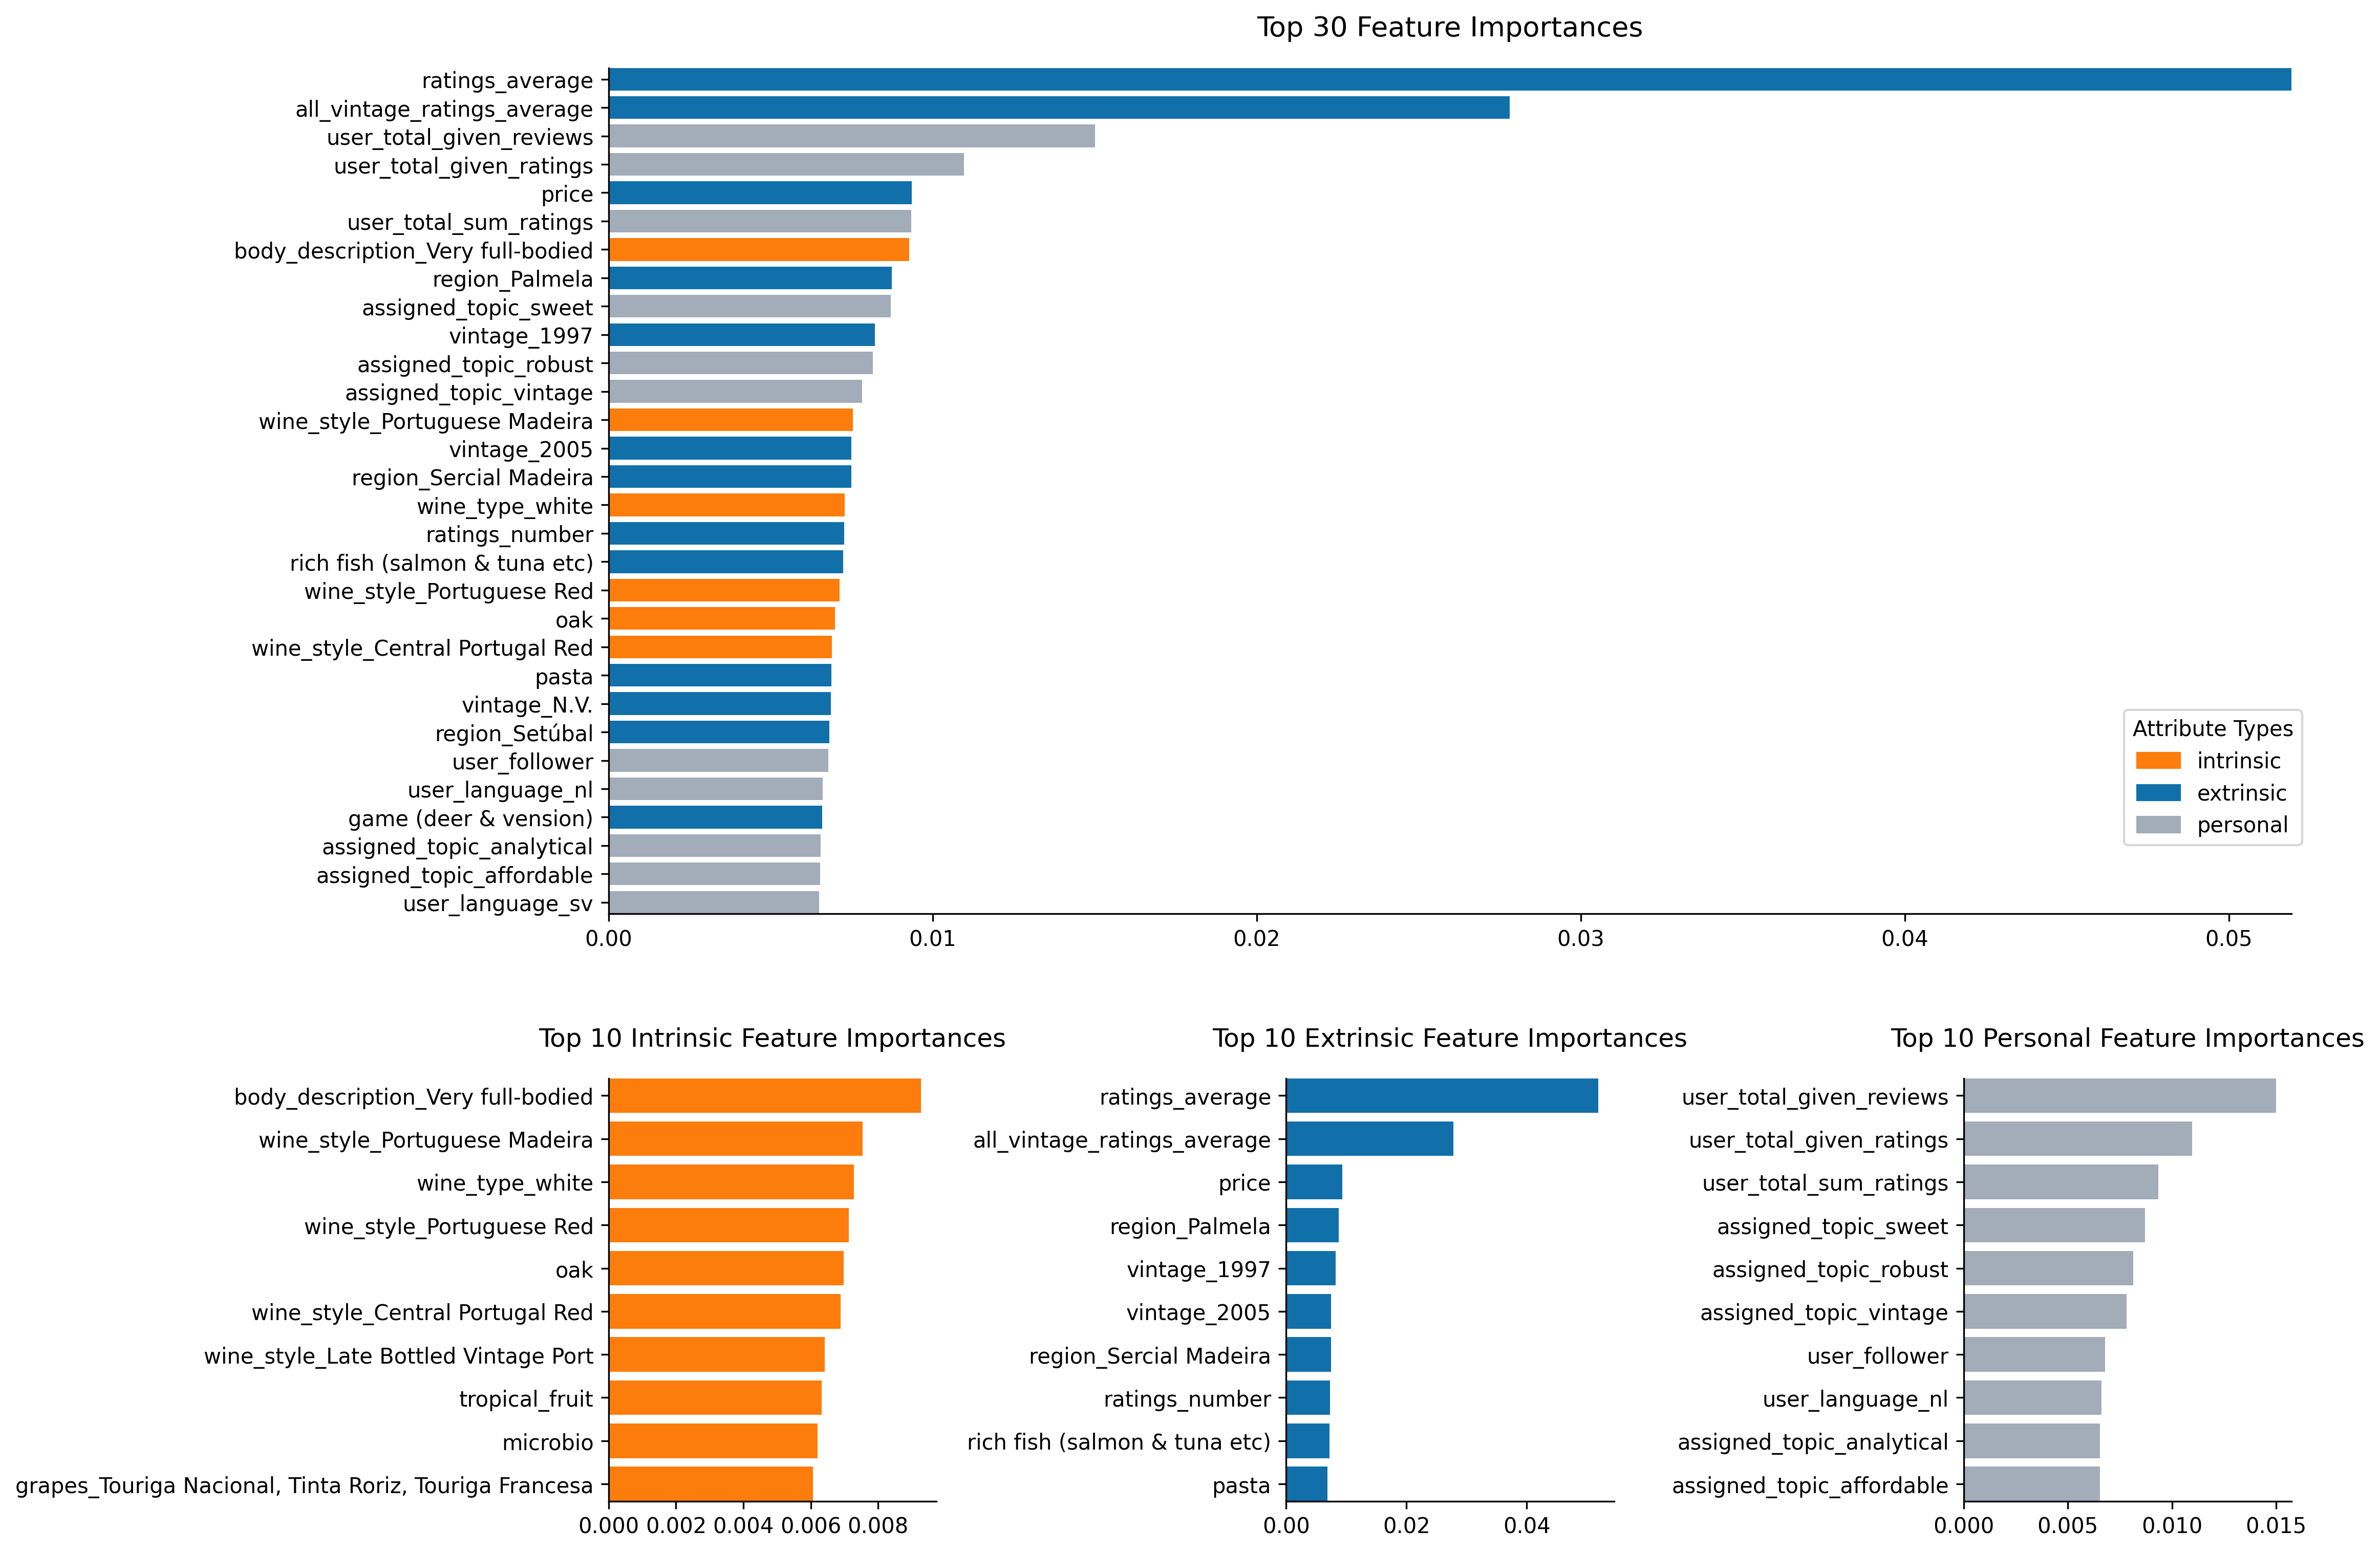

In [39]:
evaluate(xgb_clf)

In [40]:
# Make predictions on the test set
y_pred_proba = xgb_clf.predict_proba(X_train)  # Get probabilities for each class

# Calculate the ROC AUC score for multiclass classification
roc_auc = roc_auc_score(y_train, y_pred_proba, multi_class='ovr')

print(f"ROC AUC Score on Train Set: {roc_auc}")

ROC AUC Score on Train Set: 0.9182336544603772


In [41]:
# Make predictions on the test set
y_pred_proba = xgb_clf.predict_proba(X_test)  # Get probabilities for each class

# Calculate the ROC AUC score for multiclass classification
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"ROC AUC Score on Test Set: {roc_auc}")

ROC AUC Score on Test Set: 0.7392800913206178


In [42]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.2 MB/s eta 0:00:00


In [45]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from xgboost import XGBClassifier

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 80)
    max_depth = trial.suggest_int("max_depth", 10, 20)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
    alpha = trial.suggest_float("reg_alpha", 0.1, 5.0)
    subsample = trial.suggest_float("subsample", 0.8, 0.9)
    min_child_weight = trial.suggest_int("min_child_weight", 10, 20)

    # Add more parameters as needed
    # ...

    params = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'reg_alpha': alpha,
        'subsample': subsample,
        'min_child_weight': min_child_weight,
        # ... other parameters
    }

    # Creating the XGBClassifier model
    model = XGBClassifier(**params)

    # Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=5)

    # Custom scoring function for multi-class ROC AUC
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=roc_auc_scorer)

    # Average ROC AUC score across all folds
    return scores.mean()

def early_stopping_callback(study, trial):
    if study.best_trial.number + 10 <= trial.number:
        study.stop()

[I 2023-12-31 12:29:50,965] A new study created in memory with name: no-name-cba8df7a-0ac2-46d3-b9cb-f29d0f3fc8a3
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:29:52] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:30:14] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:30:32] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:30:50] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:16

Train accuracy: 0.535776770093191

Test accuracy: 0.4716957554046736

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00       326
           3       0.00      0.00      0.00       445
           4       0.26      0.05      0.08      2249
           5       0.40      0.28      0.33      4454
           6       0.49      0.85      0.62     10477
           7       0.45      0.20      0.28      3395
           8       0.49      0.15      0.23      2471

    accuracy                           0.47     24007
   macro avg       0.23      0.17      0.17     24007
weighted avg       0.43      0.47      0.40     24007




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


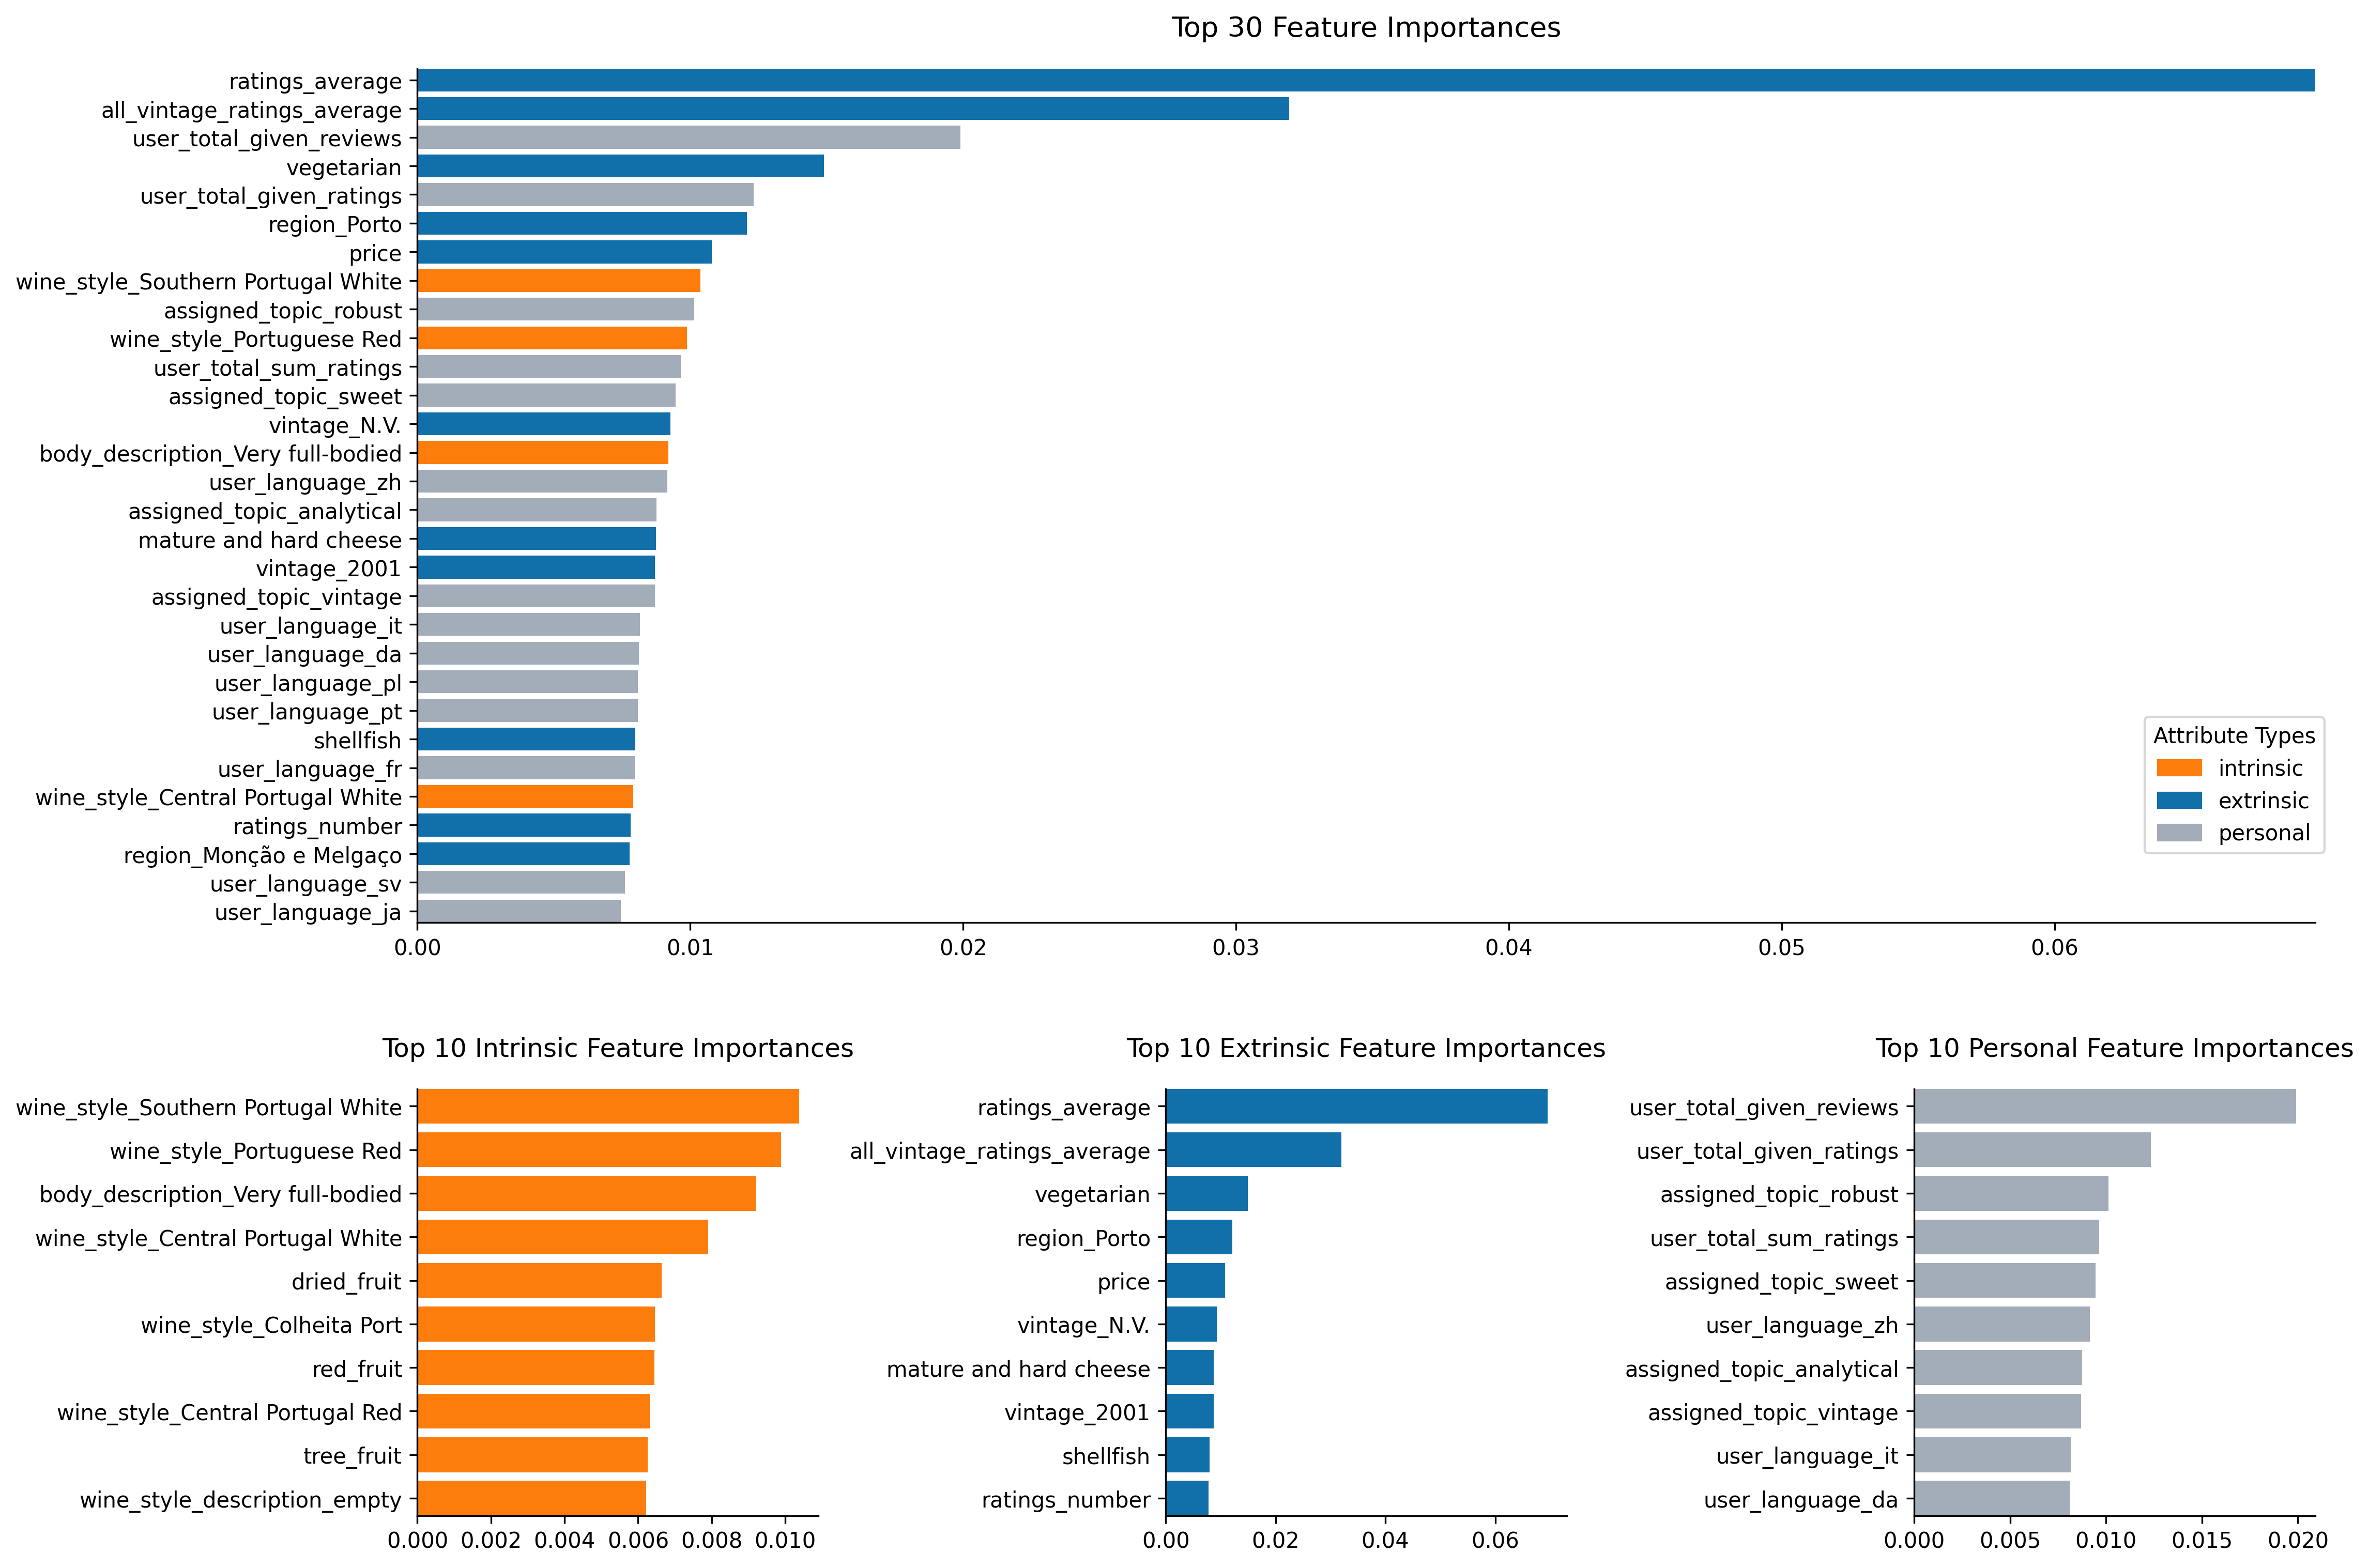

In [50]:
# Create a study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, callbacks=[early_stopping_callback])

# Retrieve the best model
best_model = XGBClassifier(**study.best_params, random_state=0)
best_model.fit(X_train, y_train)

evaluate(best_model)

In [51]:
# Make predictions on the test set
y_pred_proba = best_model.predict_proba(X_test)  # Get probabilities for each class

# Calculate the ROC AUC score for multiclass classification
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"ROC AUC Score on Test Set: {roc_auc}")

ROC AUC Score on Test Set: 0.7520044725370499
